In [146]:
import warnings

warnings.filterwarnings("ignore")

import os
hf = r'../outputs/4.2_students_needs/'
os.makedirs(hf, exist_ok=True)

# 4.2 Student Needs and Preferences

As part of behavioural studies, an online survey of student dormitory users was conducted, in which more than 100 people took part.

The survey of Berlin students partially reproduces and refines the study by Von Wittenhorst Zu Sonsfeld and Beusker conducted in 2024 in the German city of Aachen. 

As part of the study, the survey was published in thematic groups on housing search, and was also distributed in the form of QR codes on the campus of the Technical University of Berlin (TU) and Studierendenwerk Berlin accommodations.

## Set Up

Import Libraries

In [147]:
import pandas as pd
import geopandas as gpd
import chardet
import gspread
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from pywaffle import Waffle
import numpy as np
from matplotlib.patches import Patch
from math import pi

Colors 

In [148]:
from matplotlib.colors import LinearSegmentedColormap

colors= ["#FFE5D9", "#FFD7BA", "#FEC89A", "#FFB78F", "#F49F7D", "#F28B6D", "#E1755CFF"]

Font

In [149]:
plt.rcParams["font.family"] = "Helvetica"

Scripts

In [150]:
import pandas as pd          
import matplotlib.pyplot as plt  

def plot_pie_chart(column_name, title=None):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame")
        return
    
    # Count values and prepare data
    value_counts = df[column_name].value_counts()
    total = value_counts.sum()
    

    # Custom function to show count and percentage
    def make_autopct(values):
        def my_autopct(pct):
            count = int(round(pct * total / 100.0))
            return f"{pct:.1f}%\n[{count}]"
        return my_autopct

    # Create pie chart
    plt.figure(figsize=(8, 8))
    patches, texts, autotexts = plt.pie(
        value_counts,
        labels=value_counts.index,
        colors=colors[:len(value_counts)],
        autopct=make_autopct(value_counts),
        startangle=90,
        textprops={'fontsize': 12}
    )
    
    # Equal aspect ratio ensures pie is drawn as circle
    plt.axis('equal')  
    
    # Set title (use column name if no custom title provided)
    if not title:
        title = f"Distribution of {column_name}"
    plt.title(title, fontsize=14, pad=20, weight='bold')
    
    # Improve label readability
    plt.setp(texts, size=12)
    plt.setp(autotexts, size=10, color='black')
    
    plt.tight_layout()

    plt.savefig(os.path.join(hf, f"{column_name}_pie_chart.png"))

    plt.show()


In [151]:
import pandas as pd          
import matplotlib.pyplot as plt  

def plot_bar_chart(column_name, title=None, rotate_labels=True):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame")
        return

    value_counts = df[column_name].value_counts()
    total = value_counts.sum()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(value_counts.index,
                   value_counts.values,
                   color=colors[:len(value_counts)])

    # add 15 % breathing room above tallest bar
    plt.ylim(0, value_counts.max() * 1.15)

    # annotate bars
    for bar, value in zip(bars, value_counts.values):
        pct = 100 * value / total
        plt.text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + value_counts.max() * 0.02,  # a little above the bar
                 f"{pct:.1f}%\n[{value}]",
                 ha='center', va='bottom', fontsize=10)

    if not title:
        title = f"Distribution of {column_name}"
    plt.title(title, fontsize=14, pad=15, weight='bold')
    plt.ylabel("Count")

    if rotate_labels:
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(hf, f"{column_name}_bar_chart.png"))

    plt.show()

## Data Mining

The input data for the analysis was tabular data downloaded from Google Forms responses.

In [ ]:
fp = r"../inputs/4.2_students_needs/student_experience_090126.xlsx" 

df = pd.read_excel(fp)

In [ ]:
columns_to_drop = [
    'Отметка времени',
    'Баллы',
    'Briefly describe your experience with discrimination',
    'What was your biggest challenge in your apartment search?',
    'How has Berlin’s housing crisis affected your search?',
    'What policies could improve student housing in your eyes?'
]

df.drop(columns= columns_to_drop, inplace=True, errors='ignore')

The survey consists of 34 questions, designed to take a total of 10-15 minutes to complete, and consists of three thematic sections:

**Personal Data**   
The first section is aimed at collecting basic socio-demographic and contextual information necessary to understand the profile of respondents and correctly interpret behavioural patterns in the student housing market.  

*Socio-demographic characteristics*      
- gender
- age group    
- origin (`origin`)  
- study status (`stat`)     
These questions allow us to analyse whether housing problems vary between different social groups and help to determine whether international students face a higher degree of market pressure than local students.  

*Financial and housing information*     
- residential address (`adr`)
-  postcode (`plz`) 
-  current rent (`price`),
-  sources of funding (`fin`)
-  housing model (`model`)  
These questions provide insight into budget constraints and types of accommodation.  

This block forms the basis for analysis and helps answer the question: **Who are the users of student accommodation?**

**Needs and Preferences**    
The second section is devoted to identifying the factors that determine the choice of housing, subjective assessment of needs and living conditions. The structure of the section reflects the key parameters of housing affordability, location choice, mobility behaviour and social environment.  

*Affordability*
The questions assess the financial component of current housing:
- monthly rent within budget (`a_price`) — whether the rent is in proportion to personal budget.
- price matches apartment condition (`a_cond`) — subjective perception of the fairness of the cost.    
- hidden costs (`a_hidd`) — the presence of additional financial barriers (deposits, commissions).  
This block allows us to assess the degree of financial stress and identify the gap between expectations and market reality.

*Location & Proximity*  
This measures the significance of spatial factors:  
- proximity to the university (`l_uni`);  
- accessibility of the ring-bahn as a key transport axis (`l_ring`); 
- availability of inexpensive food (Mensa) (`l_mensa`);
- availability of green areas (`l_green`);
- proximity to shops and essential services (`l_grocer`).    
This data allows us to assess which amenities have the greatest influence on the choice of place of residence.    

*Transportation*    
The questions are aimed at assessing the quality of the transport infrastructure:  
- quality and frequency of public transport (`t_connect`);      
- cycling infrastructure (`t_bike`);     
- availability of night transport (`t_night`).       
This block is critical for understanding how students commute to and from university and how important this is to them.   

*Social & Living Conditions*    
The questions clarify the quality of the social environment:    
- neighbourhood safety (s_safe);   
- access to cultural/student events (s_cultur);
- proximity to student communities (s_common);
- friendliness towards international students (s_env);
- inclusiveness (s_incl).  
This section identifies how the social atmosphere affects satisfaction with accommodation and choice of neighbourhood.  

**Difficulties and Satisfaction**   
The third section explores the subjective experience of finding accommodation, stress levels and potential barriers, including discrimination. 

*The housing search process*  
- method of finding housing (`way`);  
- duration of the search (`term`); 
- existence of a long-term contract (`longtermagree`);    
- number of applications submitted (`applic_count`).  
These questions provide insight into the time and effort required to integrate into the rental market.  

*Emotional and social impact*   
- level of stress when searching for housing (`stress`);  
- level of satisfaction with current housing (`satisfied`).     
This helps to identify the degree of individual market pressure.    

*Problems and discrimination*  
- the existence of difficulties (`diff`);  
- types of discrimination (`discrimination`).    
These questions allow us to analyse the vulnerability of different groups of students and assess the social justice of the market.   

The interpretation of the third section is beyond the scope of this chapter and will be discussed in more detail in the next chapter, Students' Experiences.

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 34 columns):
 #   Column                                                                  Non-Null Count  Dtype 
---  ------                                                                  --------------  ----- 
 0   Gender                                                                  103 non-null    object
 1   Age Group                                                               103 non-null    object
 2   Origin                                                                  103 non-null    object
 3   University                                                              103 non-null    object
 4   Study Status                                                            103 non-null    object
 5   Address (street & house number)                                         59 non-null     object
 6   Postal Code                                                             103 non-null    ob

When working with survey responses, standard data preparation operations used in data science were performed.

First, the columns and response categories were renamed to shorter and more uniform designations. This simplified data access made the code more compact and ensured uniformity in the structure of the dataset.

In [155]:
# Clean up any hidden characters
df.columns = df.columns.str.strip().str.replace('\xa0', ' ', regex=False)

# Renaming colums for data clarity
df = df.rename(columns={
    'Gender': 'gender',
    'Age Group': 'age',
    'Origin': 'origin',
    'University': 'uni',
    'Study Status': 'stat',
    'Address (street & house number)': 'adr',
    'Postal Code': 'plz',
    'Current Rental Price': 'price',
    'Sources of Financing': 'fin',
    'Housing Model': 'model',
    'Monthly Rent Within Budget': 'a_price',
    'Price Matches Apartment Condition': 'a_cond',
    'Hidden Costs (deposit, agency fees)': 'a_hidd',
    'Proximity to the University': 'l_uni',
    'Proximity to the Ring-Bahn': 'l_ring',
    'Proximity to the Mensa (or affordable food options)': 'l_mensa',
    'Proximity to Green Spaces (parks, canals)': 'l_green',
    'Proximity to Grocery Stores/Essential Services': 'l_grocer',
    'Quality of public transport connections (frequency, reliability)': 't_connect',
    'Bike-friendly infrastructure (storage, parking places, bicycle paths)': 't_bike',
    'Night transport options (for late classes/part-time work)': 't_night',
    'Safety in the Neighborhood': 's_safe',
    'Access to Cultural/Student events': 's_cultur',
    'Proximity to Student Communities': 's_common',
    'International student-friendly environment': 's_env',
    'Inclusivity': 's_incl',
    'How did you find your accomodation in Berlin?': 'way',
    'How long have you searched for your long term accommodation in Berlin?': 'term',
    'Do you have a Long Term Rental Agreement?': 'longtermagree',
    'How stressful would you describe your housing search?': 'stress',
    'How many accommodations did you apply for?': 'applic_count',
    'How satisfied are you with your current housing situation?': 'satisfied',
    'Did you experience any kinds of difficulties?': 'diff',
    'What kind of discrimination did you have to face with?': 'discrimination'
})

In [156]:
#Renaming long answers
model_mapping = {
    "Studierendenwerk Dorms (State-subsidised student housing)": "PBSA",
    "PBSA (e.g., Neon Wood – private investor housing with high amenities)": "PBSA",
    "Wohngemeinschaften (WGs – shared flats, informal sublets)": "Wohngemeinschaften (WG)",
    "Living at Home (with family, commuting)": "Living at Home",
    "Commons / Co-ops (e.g., STUK - self-managed, solidarity-based housing)": "Co-ops / Commons",
    "PPPs (e.g., Camplus – public-private university housing models)": "PPP Housing",
    "Private Apartment / Studio": "Private Apartment"
}

#Apply the renaming
df["model_short"] = df["model"].replace(model_mapping)

Secondly, since the correct type of variables is critical for further analysis, numerical indicators were converted from text format to numerical format. This made it possible to perform statistical calculations, construct distributions, and apply quantitative analysis methods.

In [157]:
int_columns = [
    'a_price', 'a_cond', 'a_hidd', 'l_uni', 'l_ring', 'l_mensa', 'l_green',
    'l_grocer', 't_connect', 't_bike', 't_night', 's_safe', 's_cultur',
    's_common', 's_env', 's_incl', 'stress', 'satisfied'
]


for col in int_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

Thirdly, multiple-choice questions were standardised: answers were broken down into binary indicators (dummy variables), which made it possible to correctly account for each selected option when modelling and analysing frequencies. This approach ensures data interpretability and prevents the loss of information that is characteristic of aggregated text fields. In addition, gaps were eliminated, and categories were brought into a uniform format.

In [158]:
fin_categories = ['Public Funding', 'Private Support', 'Part-Time Job', 'Scholarship']

# Step 1: Clean and split the values
df['fin_e'] = (
    df['fin']
    .str.split(',')  # Split by comma
    .apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else [])
    .apply(lambda x: [item for item in x if item])  # Remove empty strings
)

In [159]:
df['discrimination'] = df['discrimination'].replace(
    'I didn\'t face Discrimination',  # Value to replace
    pd.NA  # Replacement value (null)
)

discrimination_categories = ['Nationality', 'Language', 'Gender', 'Economic', 'Sexual Orientation']

# Step 1: Clean and split the values
df['discrimination_e'] = (
    df['discrimination']
    .str.split(',')  # Split by comma
    .apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else [])
    .apply(lambda x: [item for item in x if item])  # Remove empty strings
)

In [160]:
diff_categories = ['Limited Affordable Options', 'Too Much Competition', 'No Responses', 'Discrimination', 'Scams', 'Other']

# Step 1: Clean and split the values
df['diff_e'] = (
    df['diff']
    .str.split(',')  # Split by comma
    .apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else [])
    .apply(lambda x: [item for item in x if item])  # Remove empty strings
)

Together, these steps provided a clean, consistent, and analysable dataset that meets the methodological requirements of quantitative behavioral research. 

# Users Personal Data

## Student Status

The majority of survey participants (98.1%) were university students, including undergraduates, postgraduates and college students (Figure XX). This group constitutes the core user base of student accommodation and most accurately reflects the typical demand for long-term, affordable housing near universities. 

However, it is important to emphasise that student accommodation in Berlin serves a much wider range of educational tracks. A significant proportion of users are applicants from other countries who are studying at a preparatory college (Studienkolleg) and preparing to enrol at universities in the German capital. These students have specific needs related to their short stay and high dependence on the availability of housing when taking their first steps in a new country.

Exchange students, including participants in Erasmus and Double-Degree programs, form a separate category. Unlike regular university students, they are mainly interested in short-term rentals of 3 to 12 months, which creates additional seasonal and structural demand for flexible, temporary forms of accommodation.

In addition, the urban student ecosystem includes students at higher levels of education — doctoral students, graduates seeking additional qualifications, interns, and young research and teaching staff. Their housing needs vary greatly, ranging from short-term stays during internships to long-term accommodation near research institutes.

All of these groups represent a significant research gap, as they fall outside the scope of both the original study by Von Wittenhorst Zu Sonsfeld and Beusker (2024) and the current work. Their inclusion requires separate analysis, as they create additional hidden demand, which in practice increases the burden on the student housing market but is rarely taken into account in regulatory and statistical assessments.

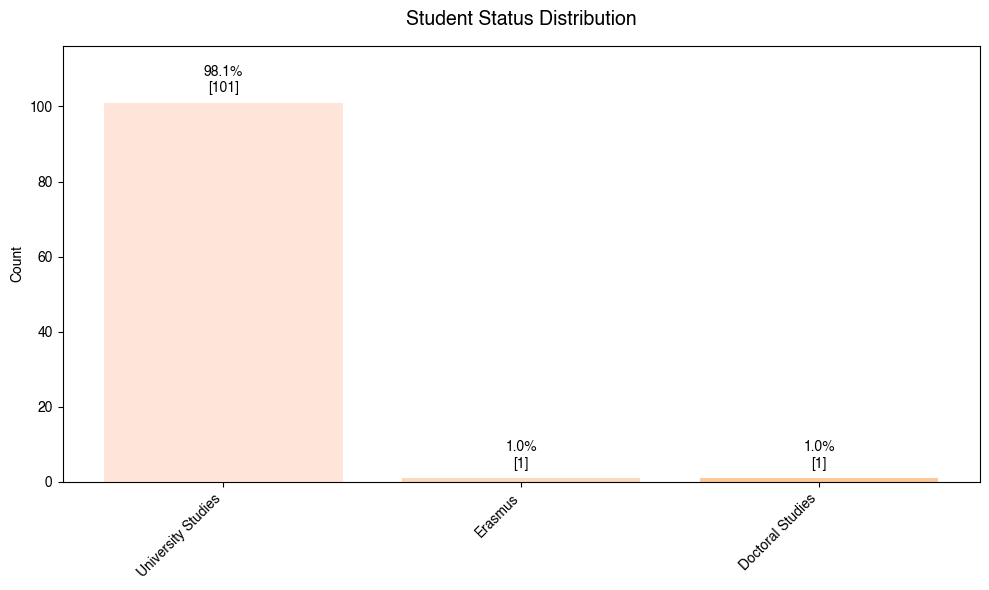

In [161]:
plot_bar_chart("stat", title="Student Status Distribution")

*Figure XX. Student Status Distribution*

## Age

According to the survey results, the largest groups were students aged 24–26 (30.1%) and 21–23 (29.1%), who together make up almost two-thirds of the entire sample. These age categories reflect the typical structure of Berlin's student population, which is dominated by senior undergraduate and master's students.

The younger group — students under the age of 21 — accounts for 17.5%, which corresponds to the proportion of first-year students and students in preparatory programs. The remaining categories — 27–29 years old and over 30 years old — include late starters, doctoral students, participants in international programs, and young professionals who combine work with study; each of these groups accounts for 11.7%.

The data on student age obtained from the survey is consistent with the official statistics from Statistik Berlin Brandenburg (2025), where 57.8% of students are over 25 years old. 

Thus, the age distribution (Figure XX) shows a predominance of mature students in the later stages of their studies, which influences their housing preferences, level of independence, and requirements for the quality and affordability of housing.

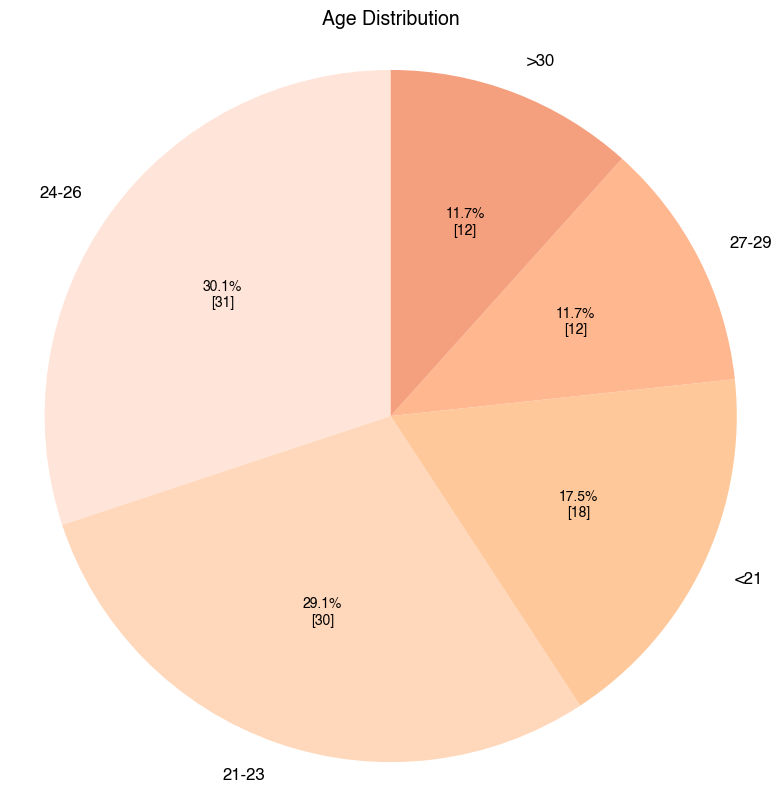

In [162]:
plot_pie_chart("age", title="Age Distribution")

*Figure XX. Age Distribution*

## Origin

Most of the survey participants are international students, with the majority coming from non-European countries (Non-EU) — 75.7%, while students from European Union countries make up another 13.6% of the sample. Only 10.7% of participants are German citizens.

This distribution is fully consistent with the target audience of the study, which focuses on analysing the living conditions and barriers faced by international students — the group experiencing the most significant difficulties in the Berlin rental market.

The high proportion of non-EU students further reflects Berlin's growing international appeal as an educational center and highlights the relevance of studying the pressure on the student housing market.

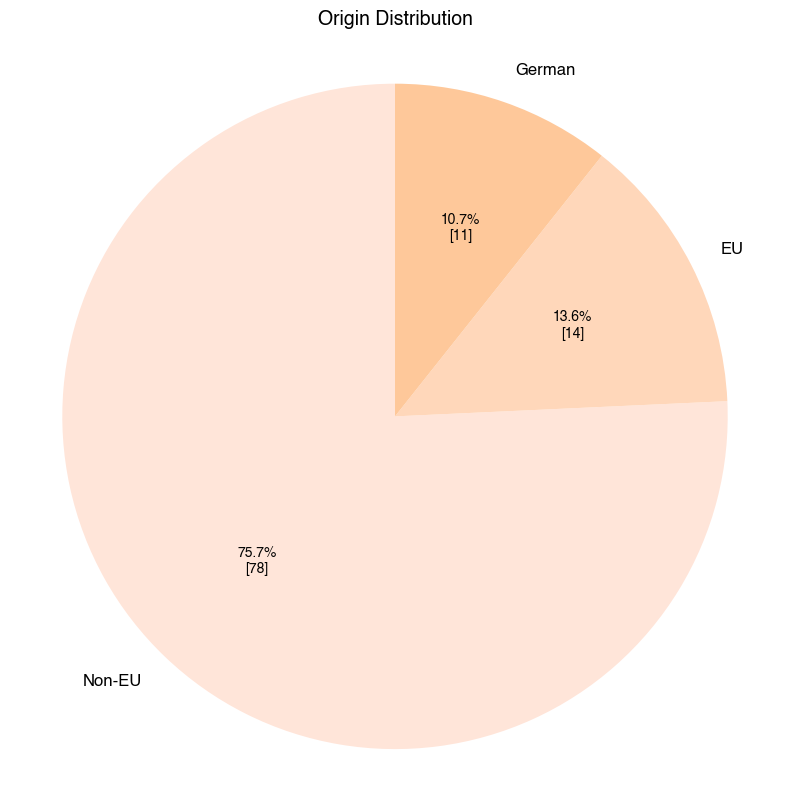

In [163]:
plot_pie_chart("origin", title="Origin Distribution")


*Figure XX. Origin Distribution*

## Housing Model

Students in Berlin use a wide range of accommodation models, each with its own structural features, advantages, risks and local context. These models form a heterogeneous student housing market, where public mechanisms coexist with the private sector, cooperatives and informal solutions. Let us consider three of them that are most frequently mentioned in the literature.

**Purpose-Built Student Accommodation (PBSA)**
Purpose-Built Student Accommodation can be divided into two categories: public and private. 

State-owned purpose-built student accommodation is funded and managed by public agencies and is the most affordable form of student housing. Its key advantages are low cost and social diversity among residents. However, limited capacity and long waiting lists significantly reduce their availability. This makes them a scarce resource and increases pressure on other types of housing.

Private purpose-built student accommodation is an investment-oriented segment of student housing, offering modern infrastructure, additional services and the possibility of immediate occupancy. At the same time, such properties are very expensive, which makes them inaccessible to many students and contributes to spatial segregation. 

Although 53.4% of users indicated that they live in PBSAs, in reality, only 5-6% of students in Berlin live in PBSAs. The majority of students live in shared flats or other corporate models due to the predominantly rental housing situation in Germany (Janet Merkel, 2025).

**Wohngemeinschaften (WGs)**
One of the most common forms of accommodation for students in Berlin is shared rented flats with an informal system of renting and subletting. The most important advantages of WGs are flexibility, affordability and a high level of social interaction. However, such conditions are often accompanied by instability, short-term contracts and discrimination when moving in, which particularly affects foreign students.

**Living at Home**  
This option involves living in the parental home with daily commutes to the place of study. It ensures no or minimal rental costs, but increases the risk of social isolation and imposes time costs associated with long commutes. Unlike in Eastern European countries, this model is much less common in Berlin (Janet Merkel, 2025).

With regard to Housing Model Distribution (Figure XX), the survey results are heavily skewed towards users of purpose-built student accommodation, as the main target group of the study. 

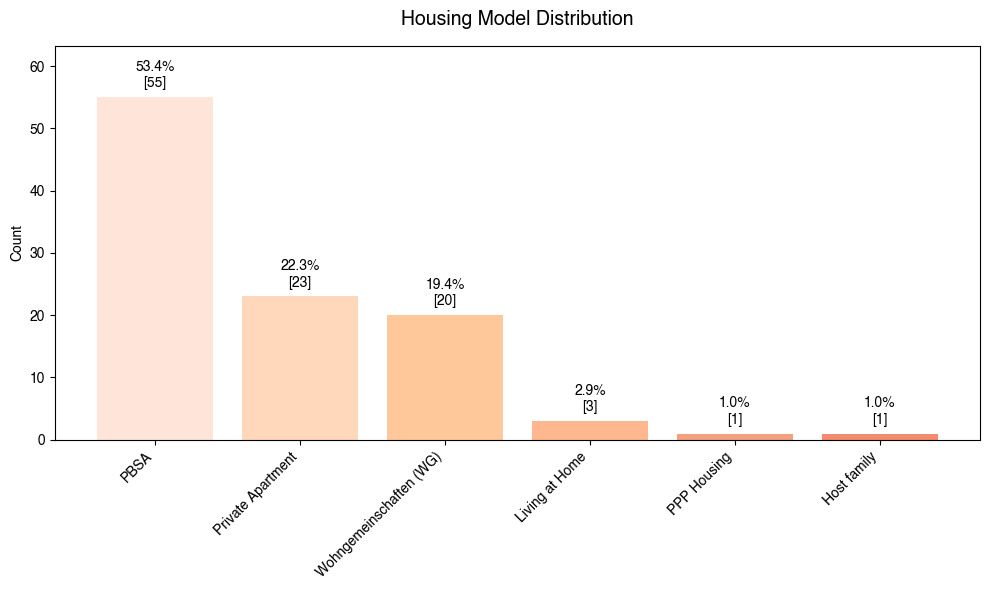

In [164]:
plot_bar_chart("model_short", title="Housing Model Distribution")

*Figure XX. Housing Model Distribution*

## Sources of Financing  

According to the survey results (Figure XX), the most common source of financing for students' educational and personal expenses is part-time employment: almost half of the respondents (47.3%) work alongside their studies to cover their daily expenses and living costs.

A significant proportion of respondents (36.6%) receive financial support from private individuals, most often from parents or relatives. However, formal support mechanisms, such as government funds (5.3%) and academic scholarships (6.9%), are used relatively rarely, which highlights the limited official channels of assistance for foreign students.

It is particularly telling that 81.3% of students identify rent as their largest expense. This confirms the key finding of the study: the cost of living in Berlin has a decisive influence on students' economic behavior and constitutes the main financial pressure affecting both their choice of place of residence and the need for additional employment.

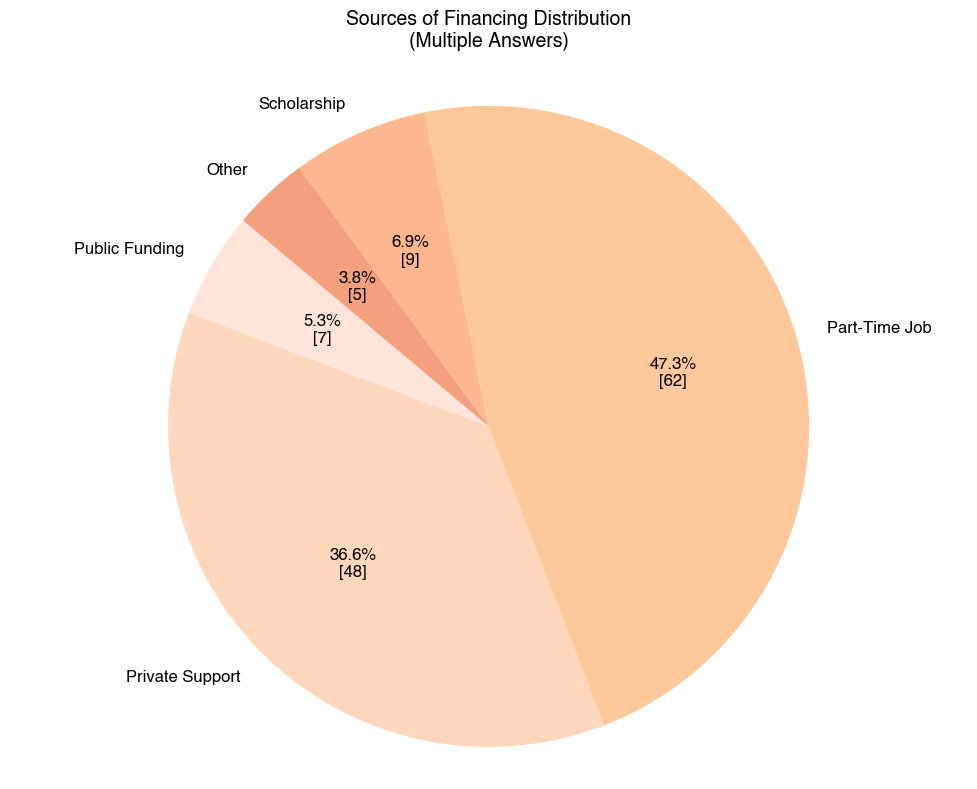

In [165]:
fin_categories = ['Public Funding', 'Private Support', 'Part-Time Job', 'Scholarship']

colors = ["#FFE5D9", "#FFD7BA", "#FEC89A", "#FFB78F", "#F49F7D", "#F28B6D", "#E1755CFF"]

# Create an empty counter
fin_counts = {cat: 0 for cat in fin_categories}
fin_counts['Other'] = 0

# Count occurrences (handling multiple answers per student)
for entry in df['fin'].dropna():
    # Convert to lowercase and split multiple answers
    entries = [e.strip().lower() for e in str(entry).split(',')]
    matched = False
    for cat in fin_categories:
        if any(cat.lower() in e for e in entries):
            fin_counts[cat] += 1
            matched = True
    if not matched and entries:  # Only count as 'Other' if non-empty
        fin_counts['Other'] += 1

# Convert to DataFrame for plotting
fin_df = pd.DataFrame(list(fin_counts.items()), columns=['Source', 'Count'])

# Define autopct function with access to counts
def make_autopct(values):
    total = sum(values)
    def my_autopct(pct):
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n[{count}]"
    return my_autopct

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(fin_df['Count'], 
        labels=fin_df['Source'], 
        autopct=make_autopct(fin_df['Count']),
        startangle=140, 
        colors=colors[:len(fin_counts)],
        textprops={'fontsize': 12})
plt.title('Sources of Financing Distribution\n(Multiple Answers)', 
          fontsize=14, weight='bold', pad=20)
plt.axis('equal')

save_path = os.path.join(hf, "Sources of Financing Distribution (Multiple Answers).png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


*Figure XX. Sources of Financing Distribution*

# Needs and Preferences

In the second part of the survey, the target audience was asked to answer the question: what is most important when looking for housing? This helps to identify the needs and preferences of international students across the city.

The **Affordability** category covers issues such as whether the rent fits the budget, whether the price is commensurate with the quality of the accommodation, and whether there are any hidden costs. The **Location & Proximity** block records students' spatial preferences, including proximity to the university, everyday infrastructure and leisure areas. **Transportation** reflects accessibility and quality of mobility, while **Social & Living** Conditions describes the social environment, sense of security, inclusiveness, and access to student communities.

To ensure comparability of results, all responses were converted to a numerical format and aggregated within the relevant groups. For each question, respondents were asked to rate the importance of a particular factor on a scale from 1 (not important at all) to 10 (extremely important). In addition, a uniform order of display of indicators was established, which made it possible to maintain the logical structure of the analysis and ensure consistent interpretation of the results both at the level of individual indicators and at the level of thematic blocks.

Thus, this stage of the analysis serves as a diagnostic cross-section, allowing us to identify key areas of tension and satisfaction in students' perceptions of the Berlin housing market and to create a basis for further research of subjective assessments.

## General Statistics

As a preliminary analysis of the data, similar to the Descriptive Market Statistics chapter, a generalised summary statistics assessment of respondents' answers was conducted across four key thematic topics reflecting the main dimensions of the student housing experience: affordability, location and proximity, transportation, and social and living conditions.

In [166]:
group_columns = {
    'Affordability': ['a_price', 'a_cond', 'a_hidd'],
    'Location & Proximity': ['l_uni', 'l_ring', 'l_mensa', 'l_green', 'l_grocer'],
    'Transportation': ['t_connect', 't_bike', 't_night'],
    'Social & Living Conditions': ['s_safe', 's_cultur', 's_common', 's_env']
}

order = [
    'a_price', 'a_cond', 'a_hidd', 'Affordability',
    'l_uni', 'l_ring', 'l_mensa', 'l_green', 'l_grocer', 'Location & Proximity',
    't_connect', 't_bike', 't_night', 'Transportation',
    's_safe', 's_cultur', 's_common', 's_env', 's_incl', 'Social & Living Conditions'
]
# 'stress', 'satisfied'

item_rename = {
    'a_price': 'Monthly Rent Within Budget',
    'a_cond': 'Price Matches Apartment Condition',
    'a_hidd': 'Hidden Costs',
    'l_uni': 'Proximity to the University',
    'l_ring': 'Proximity to the Ring-Bahn',
    'l_mensa': 'Proximity to the Mensa',
    'l_green': 'Proximity to Green Spaces (parks, canals)',
    'l_grocer': 'Proximity to Essential Services',
    't_connect': 'Quality of Public Transport Connections',
    't_bike': 'Bike-Friendly Infrastructure',
    't_night': 'Night Transport Options',
    's_safe': 'Safety in the Neighborhood',
    's_cultur': 'Access to Cultural/Student Events',
    's_common': 'Proximity to Student Communities',
    's_env': 'International Student-Friendly Environment',
    's_incl': 'Inclusivity',
    'stress': 'Level of Stress',
    'satisfied': 'Level of Satisfaction',
    'Affordability': 'Affordability',
    'Location & Proximity': 'Location & Proximity',
    'Transportation': 'Transportation',
    'Social & Living Conditions': 'Social & Living Conditions'
}

int_columns = [
    'a_price', 'a_cond', 'a_hidd', 'l_uni', 'l_ring', 'l_mensa', 'l_green',
    'l_grocer', 't_connect', 't_bike', 't_night', 's_safe', 's_cultur',
    's_common', 's_env', 's_incl'
]
#'stress', 'satisfied'
group_columns = {
    'Affordability': ['a_price', 'a_cond', 'a_hidd'],
    'Location & Proximity': ['l_uni', 'l_ring', 'l_mensa', 'l_green', 'l_grocer'],
    'Transportation': ['t_connect', 't_bike', 't_night'],
    'Social & Living Conditions': ['s_safe', 's_cultur', 's_common', 's_env']
}

Based on the descriptive statistics presented (Table XX), several key patterns can be identified in students’ preferences for living conditions.

The **Affordability** category shows the highest and most consistent ratings among all the blocks analysed. The average value for the group is 8.29 with a low standard deviation, which indicates relative uniformity of perception. The affordability of rent is particularly highly rated (mean = 9.12, median = 10), reflecting students' adaptation to financial constraints or forced compromises when choosing accommodation. At the same time, issues of hidden costs and value for money have a higher variance, indicating heterogeneous experiences and the presence of problematic cases.

The **Location & Proximity** block is characterised by a significantly lower average value (5.74) and greater variability in ratings. The most important aspect is proximity to canteens and affordable places to eat (mean = 3.52), as well as to universities and the Ring-Bahn, reflecting the spatial gap between places of study and actual areas of residence for students. At the same time, access to everyday services is rated relatively highly, indicating the compensatory role of urban infrastructure outside university clusters. 

In the **Transportation** category, there is a marked contrast between individual indicators. The quality of public transport receives one of the highest ratings in the sample (mean = 8.53), confirming the important role of Berlin's transport system as a compensatory mechanism for long-distance commuting. At the same time, cycling infrastructure is rated significantly lower (mean = 4.42) and shows high dispersion, indicating a spatially uneven distribution of bicycle-friendly conditions.

The most vulnerable group of indicators is **Social & Living Conditions**, with an average score of 5.19. Despite a relatively high sense of security in the neighbourhood, access to student communities, cultural events and a sense of an inclusive environment receive low ratings and are characterised by high variability. This indicates social fragmentation in student housing and weak integration of some students, especially international students, into local social structures.

Overall, the results of the initial analysis show that economic affordability and transport connectivity are priority factors in a stressed market.

In [167]:
import pandas as pd

# Clean column names
df.columns = df.columns.str.strip()

# Individual stats
individual_stats = df[int_columns].describe().T[['mean', 'std', 'min', '50%', 'max']].round(2)
individual_stats.rename(columns={'50%': 'median'}, inplace=True)
individual_stats.index.name = 'Item'
individual_stats.reset_index(inplace=True)

# Grouped stats
grouped_stats = []
for group_name, cols in group_columns.items():
    group_df = df[cols].mean(axis=1)  # row-wise mean for the group
    stats = {
        'Item': group_name,
        'mean': group_df.mean().round(2),
        'std': group_df.std().round(2),
#        'min': group_df.min().round(2),
        'median': group_df.median().round(2),
#        'max': group_df.max().round(2)
    }
    grouped_stats.append(stats)

group_stats_df = pd.DataFrame(grouped_stats)

# Combine both
statistics = pd.concat([individual_stats, group_stats_df], ignore_index=True)

statistics.set_index('Item', inplace=True)
statistics = statistics.loc[order].reset_index()

statistics['Item'] = statistics['Item'].replace(item_rename)

# Display result
statistics

,Item,mean,std,min,median,max
0,Monthly Rent Within Budget,9.12,1.13,5.0,10.0,10.0
1,Price Matches Apartment Condition,8.06,1.82,3.0,8.0,10.0
2,Hidden Costs,7.7,2.06,2.0,8.0,10.0
3,Affordability,8.29,1.17,<NA>,8.33,<NA>
4,Proximity to the University,6.1,2.18,1.0,6.0,10.0
5,Proximity to the Ring-Bahn,5.67,2.47,1.0,6.0,10.0
6,Proximity to the Mensa,3.52,2.4,1.0,3.0,10.0
7,"Proximity to Green Spaces (parks, canals)",5.67,2.39,1.0,6.0,10.0
8,Proximity to Essential Services,7.72,1.91,1.0,8.0,10.0
9,Location & Proximity,5.74,1.6,<NA>,5.8,<NA>


*Table XX. General Student Needs and Preferences*

Correlation analysis of student needs and preferences (Figure XX) reveals stable relationships between individual aspects of housing choice, thereby deepening the interpretation of descriptive statistics results. Overall, the correlation matrix shows moderate but structurally meaningful relationships, indicating the multidimensional nature of student housing capacity, where no single factor is completely isolated.

**Affordability** indicators show relatively weak correlations with spatial and social characteristics. Rent affordability and hidden costs are more closely related to each other than to other blocks, confirming their autonomous role in the decision-making process. This indicates that financial constraints are seen by students as a separate structural condition rather than an element of the integrated quality of the living environment.

Blocks associated with **Location & Proximity** form a dense cluster of interrelationships. Proximity to the university, the ring-bahn, the mensa, green areas, and basic services shows consistent positive correlations with each other (in the range of approximately 0.27–0.50). This indicates that students tend to view accessibility not in terms of individual objects, but as a comprehensive characteristic of the living environment. A particularly strong link is observed between proximity to the Mensa and student communities, as well as between green areas and cultural access, which emphasises the role of everyday routes and infrastructure in creating a comfortable environment.

**Transportation** indicators act as a link between spatial and social characteristics. The quality of public transport correlates moderately with proximity to key urban functions and night-time transport, reflecting the importance of the transport system as a mechanism for commuters. At the same time, cycling infrastructure shows more selective links, including a negative correlation with the sense of safety in the area, which may indicate local conflicts between different types of mobility or spatial heterogeneity of cycling conditions in the city.

**Social & Living Conditions** form a separate but interrelated cluster. Access to cultural events, proximity to student communities, an internationally friendly environment, and inclusiveness demonstrate moderate positive correlations. The strongest link is observed between student communities and an international-friendly environment, which highlights the importance of social networks and “social density” for international students. At the same time, the feeling of safety is weakly correlated with most social indicators, which may indicate a gap between the physical and social comfort of the environment.

Overall, correlation analysis confirms that student housing choices are shaped by the intersection of three factors: economic adaptation, spatial accessibility, and social integration. At the same time, it is precisely spatial and social connections that are the most structured, while financial parameters act more as a strict limitation than as an active factor in shaping preferences.

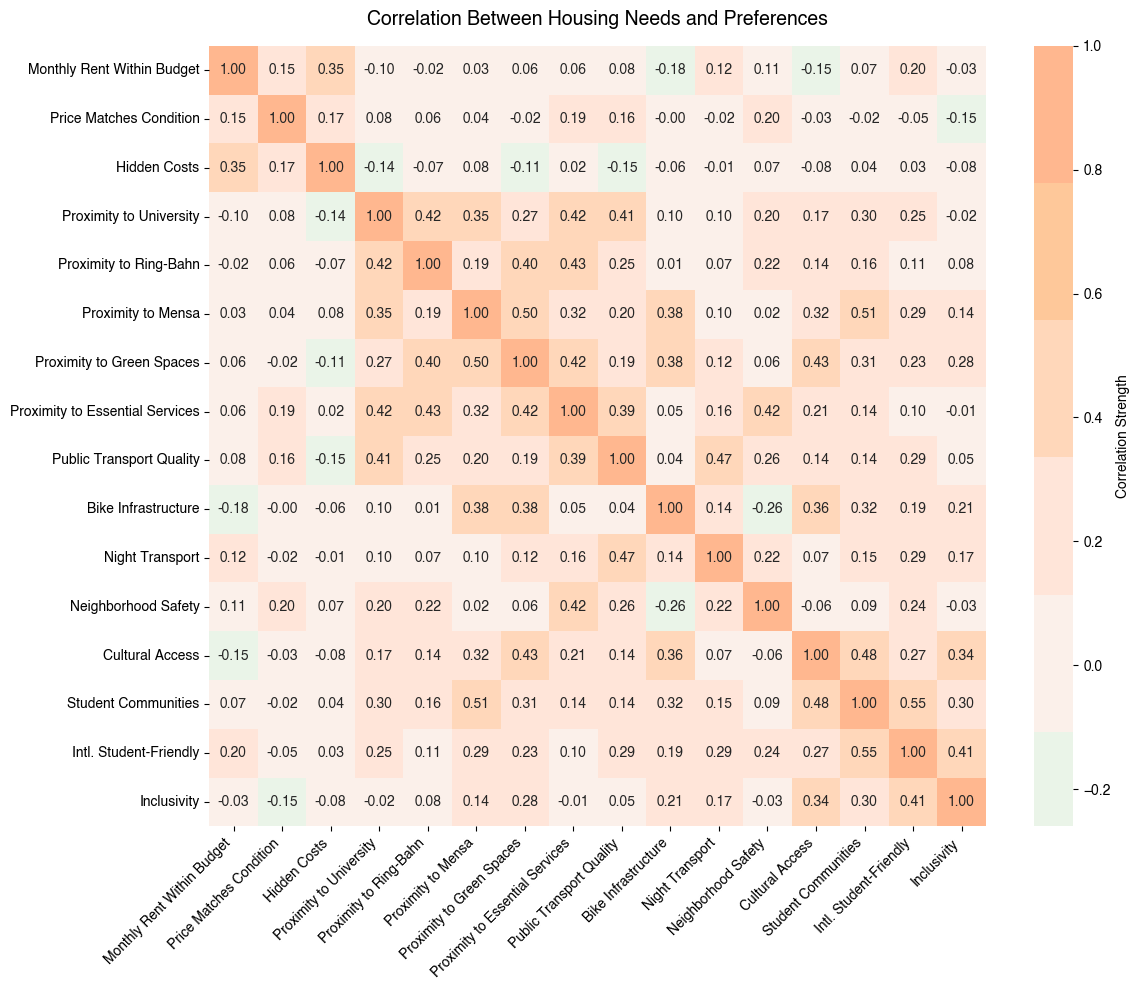

In [168]:
custom_colors = [ "#8FB9AE", "#A9CCC1", "#C8E0D4","#EAF4E8",  "#FBF0EA","#FFE5D9", "#FFD7BA", "#FEC89A", "#FFB78F"]

label_dict = {
    'a_price': 'Monthly Rent Within Budget',
    'a_cond': 'Price Matches Condition',
    'a_hidd': 'Hidden Costs',
    'l_uni': 'Proximity to University',
    'l_ring': 'Proximity to Ring-Bahn',
    'l_mensa': 'Proximity to Mensa',
    'l_green': 'Proximity to Green Spaces',
    'l_grocer': 'Proximity to Essential Services',
    't_connect': 'Public Transport Quality',
    't_bike': 'Bike Infrastructure',
    't_night': 'Night Transport',
    's_safe': 'Neighborhood Safety',
    's_cultur': 'Cultural Access',
    's_common': 'Student Communities',
    's_env': 'Intl. Student-Friendly',
    's_incl': 'Inclusivity'
}

# Define columns to analyze
loc_cols = [
    'a_price', 'a_cond', 'a_hidd', 'l_uni', 'l_ring', 'l_mensa', 'l_green',
    'l_grocer', 't_connect', 't_bike', 't_night', 's_safe', 's_cultur',
    's_common', 's_env', 's_incl'
]

# Compute correlation matrix and round to 2 decimals
corr_matrix = df[loc_cols].corr().round(2)

# Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap=custom_colors,
    center=0,
    fmt=".2f",
    cbar_kws={'label': 'Correlation Strength'}
)
ax.set_xticklabels([label_dict.get(x.get_text(), x.get_text()) for x in ax.get_xticklabels()], 
                  rotation=45, ha='right', fontsize=10)
ax.set_yticklabels([label_dict.get(y.get_text(), y.get_text()) for y in ax.get_yticklabels()], 
                  rotation=0, fontsize=10)

plt.title('Correlation Between Housing Needs and Preferences', fontsize=14, pad=15, weight='bold' )

save_path = os.path.join(hf, "Correlation Between Housing Needs and Preferences.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Correlation Between Housing Needs and Preferences*

## Statistics by Origin

In order to avoid generalising students, it is necessary to conduct a comparative analysis of students' housing needs and preferences (Table XX) depending on their country of origin (German, EU, Non-EU) and identify both common patterns and structural differences between groups.

In [169]:
# origin order and stats order
origin_order = ['German', 'EU', 'Non-EU']
stats_order = ['mean', 'std', 'min', 'median', 'max']

# Prepare list to collect data rows (one row per Item per origin category)
rows = []

# Helper: function to calc stats on a Series or array
def calc_stats(series):
    return {
        'mean': round(series.mean(), 2),
        'std': round(series.std(), 2), 
        'median': group_df.median().round(2)
    }

for origin_cat in origin_order:
    df_origin = df[df['origin'] == origin_cat]

    # Individual items stats
    for item in int_columns:
        if item in df_origin.columns:
            stats = calc_stats(df_origin[item].dropna())
            stats['Item'] = item
            stats['origin_cat'] = origin_cat
            rows.append(stats)
    
    # Grouped features stats
    for group_name, cols in group_columns.items():
        group_avg = df_origin[cols].mean(axis=1, skipna=True)
        stats = calc_stats(group_avg.dropna())
        stats['Item'] = group_name
        stats['origin_cat'] = origin_cat
        rows.append(stats)

# Create DataFrame
summary_df = pd.DataFrame(rows)

# Pivot so origin categories are columns with subcolumns = stats
statictics_byorigin = summary_df.pivot(index='Item', columns='origin_cat')

# Flatten MultiIndex columns to tuples for easier control (will be multi-level in output)
statictics_byorigin.columns.names = ['stat', 'origin_cat']
statictics_byorigin = statictics_byorigin.swaplevel(axis=1).sort_index(axis=1, level=0)  # origin_cat first, then stat

statictics_byorigin = statictics_byorigin.reindex(order)

statictics_byorigin.index = statictics_byorigin.index.to_series().replace(item_rename)

statictics_byorigin = statictics_byorigin.reindex(columns=origin_order, level=0)

statictics_byorigin

origin_cat                                 German                 EU         \
stat                                         mean median   std  mean median   
Item                                                                          
Monthly Rent Within Budget                   9.09    5.0  0.94  9.29    5.0   
Price Matches Apartment Condition            7.18    5.0  1.33  7.50    5.0   
Hidden Costs                                 7.36    5.0  1.50  8.57    5.0   
Affordability                                7.88    5.0  0.98  8.45    5.0   
Proximity to the University                  5.00    5.0  2.28  5.64    5.0   
Proximity to the Ring-Bahn                   4.55    5.0  2.77  5.21    5.0   
Proximity to the Mensa                       4.00    5.0  2.49  4.14    5.0   
Proximity to Green Spaces (parks, canals)    6.00    5.0  2.14  5.50    5.0   
Proximity to Essential Services              6.09    5.0  2.30  7.50    5.0   
Location & Proximity                         5.13    5.0  1.91  5.60    5.0   
Quality of Public Transport Connections      7.27    5.0  1.56  8.64    5.0   
Bike-Friendly Infrastructure                 6.09    5.0  2.34  3.86    5.0   
Night Transport Options                      5.45    5.0  2.07  7.50    5.0   
Transportation                               6.27    5.0  1.58  6.67    5.0   
Safety in the Neighborhood                   5.73    5.0  3.20  7.14    5.0   
Access to Cultural/Student Events            5.18    5.0  2.79  5.00    5.0   
Proximity to Student Communities             5.09    5.0  2.88  2.71    5.0   
International Student-Friendly Environment   5.36    5.0  3.47  3.93    5.0   
Inclusivity                                  5.45    5.0  2.94  6.07    5.0   
Social & Living Conditions                   5.34    5.0  2.13  4.70    5.0   

origin_cat                                       Non-EU               
stat                                         std   mean median   std  
Item                                                                  
Monthly Rent Within Budget                  0.99   9.09    5.0  1.19  
Price Matches Apartment Condition           1.87   8.28    5.0  1.83  
Hidden Costs                                1.83   7.59    5.0  2.15  
Affordability                               0.96   8.32    5.0  1.23  
Proximity to the University                 2.27   6.33    5.0  2.11  
Proximity to the Ring-Bahn                  2.67   5.91    5.0  2.36  
Proximity to the Mensa                      2.88   3.35    5.0  2.30  
Proximity to Green Spaces (parks, canals)   2.79   5.65    5.0  2.37  
Proximity to Essential Services             2.68   7.99    5.0  1.57  
Location & Proximity                        1.98   5.85    5.0  1.48  
Quality of Public Transport Connections     1.69   8.69    5.0  1.52  
Bike-Friendly Infrastructure                2.85   4.28    5.0  2.85  
Night Transport Options                     2.47   7.05    5.0  2.36  
Transportation                              1.35   6.68    5.0  1.61  
Safety in the Neighborhood                  2.60   8.41    5.0  1.77  
Access to Cultural/Student Events           3.19   4.17    5.0  2.40  
Proximity to Student Communities            1.98   3.74    5.0  2.41  
International Student-Friendly Environment  3.22   4.72    5.0  2.84  
Inclusivity                                 3.05   4.15    5.0  2.85  
Social & Living Conditions                  1.98   5.26    5.0  1.63

*Table XX. Student Needs and Preferences by Origin*

In the **Affordability** section, the differences between the groups are relatively slight. For all categories of students, the affordability of rent is rated very highly (9), confirming the universal importance of the price factor. At the same time, students from the EU and especially non-EU countries rate the value for money of housing and the importance of hidden costs slightly higher, which may reflect their lower awareness of the local market and higher costs of searching for housing. In the aggregate indicator of affordability, it is foreign students who demonstrate the highest values, which emphasises their increased sensitivity to financial constraints.

The **Location & Proximity** section shows more noticeable differences. On average, non-EU students rate proximity to the university, the ring-bahn and, in particular, basic services higher than German students. This indicates that international students are more dependent on a compact and well-served urban environment where everyday functions are accessible without complicated navigation around the city. German students, on the other hand, give lower ratings for proximity, which may be due to their better knowledge of the city and greater willingness to make spatial compromises.

The differences are most noticeable in the Transportation category. Foreign students (EU and non-EU) rate the quality of public transport and night-time transport options significantly higher, while German students tend to value cycling infrastructure more. This reflects differences in mobility practices: for local students, bicycles are a familiar mode of transport, while international students rely more on public transport, especially at night.

The Social & Living Conditions section reveals the most contrasting results. Non-EU students rate the importance of neighbourhood safety significantly higher, indicating increased vulnerability and a need for a subjective sense of security in an unfamiliar urban environment. At the same time, foreign students rate access to cultural events, student communities and an international-friendly environment lower than German students, which may indicate structural barriers to integration and limited inclusion in local social networks. German students, on the other hand, rate their proximity to student communities and cultural life higher, reflecting their more stable position in the urban and academic environment.

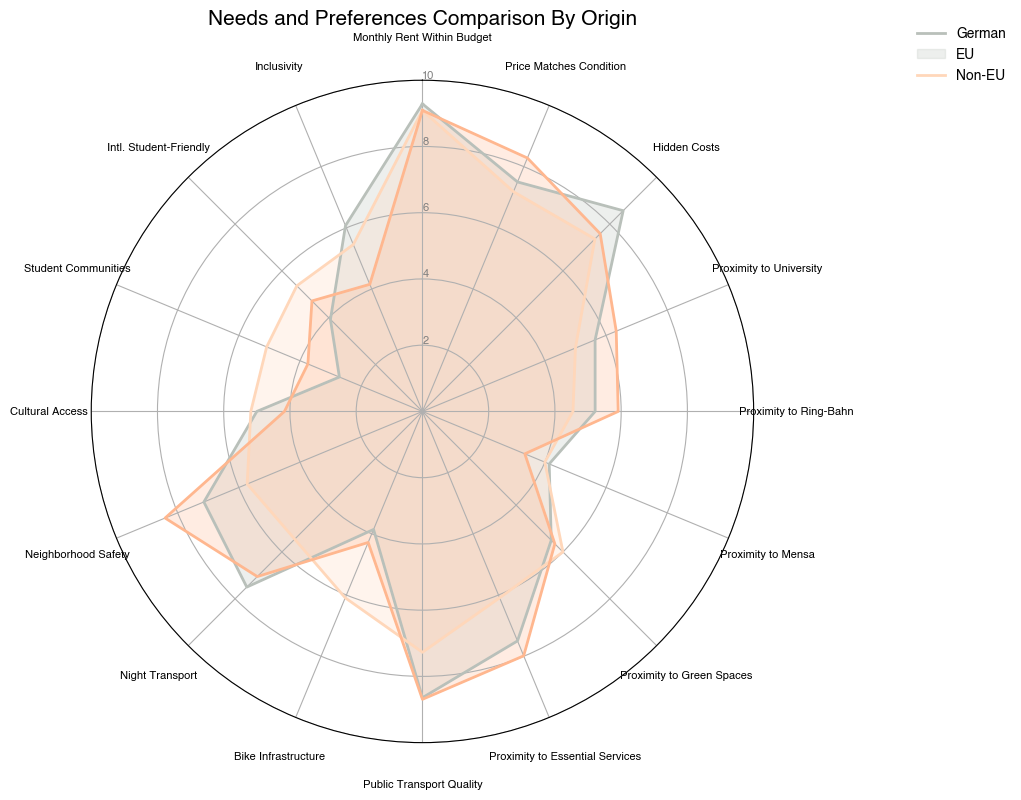

In [ ]:
price_order = ['German', 'EU', 'Non-EU']

# Label mapping
label_dict = {
    'a_price': 'Monthly Rent Within Budget',
    'a_cond': 'Price Matches Condition',
    'a_hidd': 'Hidden Costs',
    'l_uni': 'Proximity to University',
    'l_ring': 'Proximity to Ring-Bahn',
    'l_mensa': 'Proximity to Mensa',
    'l_green': 'Proximity to Green Spaces',
    'l_grocer': 'Proximity to Essential Services',
    't_connect': 'Public Transport Quality',
    't_bike': 'Bike Infrastructure',
    't_night': 'Night Transport',
    's_safe': 'Neighborhood Safety',
    's_cultur': 'Cultural Access',
    's_common': 'Student Communities',
    's_env': 'Intl. Student-Friendly',
    's_incl': 'Inclusivity'
}

# 6 most distinct pastel colors
colors = [ '#B9C0BA',"#FFD7BA", "#FFB78F"]


# Metrics and labels
metrics = list(label_dict.keys())
metric_labels = list(label_dict.values())

# Radar setup
N = len(metrics)
angles = np.linspace(0, 2 * pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Aggregate your data
agg_df = df.groupby('origin')[metrics].mean().reset_index()

# Setup figure
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw labels and grid
plt.xticks(angles[:-1], metric_labels, fontsize=8, rotation=0)
ax.tick_params(axis='x', pad=20)
ax.set_rlabel_position(0)
plt.ylim(0, 10)
plt.yticks([2, 4, 6, 8, 10], ["2", "4", "6", "8", "10"], color="grey", size=8)

# Plot each model
for idx, (_, row) in enumerate(agg_df.iterrows()):
    values = row[metrics].tolist()
    values += values[:1]  # loop
    ax.plot(angles, values, color=colors[idx % len(colors)], linewidth=2, label=row['origin'])
    ax.fill(angles, values, color=colors[idx % len(colors)], alpha=0.25)

# Title and legend
plt.title('Student Needs and Preferences by Origin', size=15, weight='bold' )
legend = plt.legend(price_order, loc='upper right', bbox_to_anchor=(1.4, 1.1), frameon=False)

save_path = os.path.join(hf, "Student Needs and Preferences by Origin.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Student Needs and Preferences by Origin*

Overall, the results (Figure XX) show that students' origins have a significant impact on the structure of their housing priorities. For international students, accessibility, transport and safety are key, while for German students, social and cultural aspects as well as alternative forms of mobility play a greater role. These differences highlight the need for a differentiated approach to analysing student housing capacity and confirm that a single ‘student’ model does not reflect the real diversity of user groups in the student housing market in Berlin.

In [171]:
df.to_excel(os.path.join(hf, "user_data.xlsx"), index=False)